# This notebook contains all models used in the lecture slides

#  Introduction: KIVA model
Only a part of the KIVA model is shown. The rest of the model can be found in the lecture notes 

In [ ]:
def model():
    N = 1      
    la = 4.0    
    mu = 20.0   

    env = Environment()
    a = Channel(env)
    b = Channel(env)
    c = Channel(env)
    G = Generator(env, a, N)
    Ss = [Storage(env, a, b, la) for j in range(N)]
    B = Buffer(env, b, c)
    P = Pick(env, c, a, mu, 10000)

    env.run()

## Week 2a: coincidence problem

In [1]:
'''
Week 2a coincidence problem
'''
from PyCh import *
from numpy import random

def acquaintance():
    success = 0
    N = 10000
    population = 200000
    frA = 200
    frB = 200
    
    for i in range(N):
        s = []
        for j in range(0, frB): # generate friends of B
            while True:
                k = random.randint(1, population)
                if k not in s:
                    break
            s = s + [k];
            ### BEGIN SOLUTION
            if k <= frA:
                success = success + 1
                break
            ### END SOLUTION
    print("Probability of common acquaintance =", (success/N) )
    
### MAIN ###
acquaintance()

PyCh version 0.2 imported succesfully.
 
Probability of common acquaintance = 0.1775


# Week 5a: GBME
Only a part of the model is shown.

In [ ]:
def model():
    ta = 1.0
    te = 1.0
    n  = 1000
    N = 10

    env = Environment()
    a = Channel(env)
    b = Channel(env)
    c = Channel(env)
    G = Generator(env, a, lambda: random.exponential(ta))
    B = Buffer(env, a, b,  N)
    M = Machine(env, b, c, lambda: random.exponential(te))
    E = Exit(env, c, n)

    env.run()

## Week 6a: central limit theorem

In [13]:
### IMPORTS
from numpy import random


### Central limit function
def centrallimit():
    n = 100
    N = 30000
    sum = 0.0
    results = []
    for i in range(N):
        sum = 0.0
        for j in range(n):
            if random.random() < 0.5:
                sum = sum + random.binomial(20, 0.1)
            else:
                sum = sum + random.binomial(20, 0.9);
        results = results + [sum]
    return results
    
# =================================
# Main
# =================================
results = centrallimit()

Now if we want, we can use the results to plot a histogram

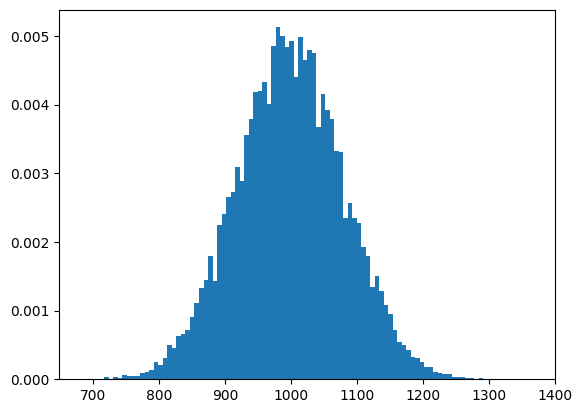

In [14]:
from matplotlib import pyplot as plt

h = plt.hist(results, density = True, bins = 100)
plt.show()

---
It is also possible to create a model which writes to an output file

In [ ]:
### Central limit function
def centrallimit_write2txt():
    n = 10
    N = 30000
    sum = 0.0
    file = open("data.txt", "w");
    for i in range(N):
        sum = 0.0
        for j in range(n):
            if random.random() < 0.5:
                sum = sum + random.binomial(20, 0.1)
            else:
                sum = sum + random.binomial(20, 0.9);
        file.write("\%g " % sum)
    write(file, "\%g ", sum);
    file.close()
    
# =================================
# Main
# =================================
centrallimit()

## Week 6a: Confidence intervals for waiting time in single machine station

In [29]:
from PyCh import *
from statistics import mean

# =================================
# Tote definition
# =================================
@dataclass
class Job:
    entrytime: float = 0
    time_entered_buffer: float = 0

# =================================
# Generator definition
# =================================
@process
def Generator(env, sending_channel, u):
    while True:
        x = Job(entrytime = env.now)
        yield env.execute(sending_channel.send(x))
        yield env.timeout(u())

# =================================
# Buffer definition
# =================================
@process
def Buffer(env, receiving_channel, sending_channel, waitingtime):
    xs = [] # list of jobs
    while True:
        receiving = receiving_channel.receive() 
        sending = sending_channel.send(xs[0]) if len(xs)>0 else None
        yield env.select(sending, receiving)
        if selected(sending):
            waitingtime.append(env.now - xs[0].time_entered_buffer)
            xs = xs[1:]
        if selected(receiving):
            x = receiving.entity
            x.time_entered_buffer = env.now
            xs = xs + [x]

# =================================
# Machine definition
# =================================
@process
def Machine(env, receiving_channel, sending_channel, tp_distribution ):
    while True:
        x = yield env.execute(receiving_channel.receive())
        yield env.timeout(tp_distribution())
        yield env.execute(sending_channel.send(x))         

# =================================
# Exit definition
# =================================
@process
def Exit(env, receiving_channel, nJobs, flowtime):
    for j in range(nJobs):
        x = yield env.select(receiving_channel.receive())
        flowtime.append(env.now - x.entrytime);

# =================================
# GBME Model
# =================================
def GBME():
    flowtime = []; waitingtime = []
    env = Environment()
    a = Channel(env)
    b = Channel(env)
    c = Channel(env)
    G = Generator(env, a,  lambda: random.uniform(0.0, 2.0))
    B = Buffer(env, a, b, waitingtime)
    M = Machine(env, b, c,  lambda: random.uniform(0.0, 1.0))
    E = Exit(env, c, 1000, flowtime)
    env.run(until=E)
    return mean(waitingtime), mean(flowtime)

# =================================
# Main
# =================================
for i in range(5):
    mean_waitingtime, mean_flowtime = GBME()
    print(f"Mean waiting time in run {i+1:d} = {mean_waitingtime:g}")
    

Mean waiting time in run 1 = 0.135008
Mean waiting time in run 2 = 0.128126
Mean waiting time in run 3 = 0.147073
Mean waiting time in run 4 = 0.20386
Mean waiting time in run 5 = 0.141099


## Week 6b: Serial production lines

We only need to redefine the exit and the model

In [ ]:
# =================================
# Model
# =================================
def model():
    flowtime = []
    waitingtime = []

    env = Environment()
    a = [ Channel(env) for i in range(3)]
    b = [ Channel(env) for i in range(2)]
    G  = Generator(env, a[0], lambda: random.exponential(0.5))
    B1 = Buffer(   env, a[0], b[0], waitingtime)
    M1 = Machine(  env, b[0], a[1], lambda: 0.33)
    B2 = Buffer(   env, a[1], b[1], waitingtime)
    M2 = Machine(  env, b[1], a[2], lambda: random.uniform(0.0, 0.8))
    E  = Exit(     env, a[2], 100000, flowtime)

    env.run()

    print(f"Mean flowtime = {mean(flowtime):g}" )
    
# =================================
# Main
# =================================
model()